## PPC spend: causal inference analysis
This notebook uses the tfcausalimpact model to build upon the limited regression-based ITS model in part 2.

References:
* https://github.com/WillianFuks/tfcausalimpact/blob/master/notebooks/getting_started.ipynb
* https://github.com/WillianFuks/tfcausalimpact?tab=readme-ov-file
* https://medium.com/data-science/implementing-causal-impact-on-top-of-tensorflow-probability-c837ea18b126

### Import libaries and functions

In [ ]:
pip install tfcausalimpact

In [1]:
import pandas as pd
import numpy as np
from causalimpact import CausalImpact   # import from 'pip install tfcausalimpact'
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.pyplot as mplt

print("✅ All imports successful!")

✅ All imports successful!


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
print("✅ Connected to Google Drive!")

Mounted at /content/gdrive
✅ Connected to Google Drive!


In [8]:
from dotenv import load_dotenv
load_dotenv()
file_path = os.getenv("FILEPATH")
file_path

### Import pre-processed data

The data has been processed (including cleaning and aggregating into weekly and monthly) in a separate notebook.

In [ ]:
master_data_monthly_adjusted = pd.read_csv(r'gdrive/My Drive/analysis/ad-hoc-analysis/2026_02_diningppc/master_data_monthly.csv')
print("✅ Dataframes imported!")

✅ Dataframes imported!


In [ ]:
master_data['date'] = pd.to_datetime(master_data['date']) # Convert date col to datetime

### Define helper functions

In [ ]:
def add_day_week_month(df):
  """
  Add day of week, week of year, month to a dataframe
  """
  df['date_temp'] = pd.to_datetime(df.index)
  df['day_of_week'] = df['date_temp'].dt.dayofweek + 1
  df['week_of_year'] = df['date_temp'].dt.isocalendar().week
  df['month'] = df['date_temp'].dt.month
  del df['date_temp']
  return df

In [ ]:
def causalimpact_dataprep(data, intervention_date, start_date = None):
    """
    Prepare data for CausalImpact model
    """
    # Filter data to after the start date
    if start_date is not None:
        data = data[data.index >= start_date]
    else:
      pass

    # Define pre-period dates
    pre_period_end = intervention_date - pd.Timedelta(days=1)
    pre_data_subset = data[data.index <= pre_period_end]

    # Ensure pre-period has enough data points
    if len(pre_data_subset) < 3:
        raise ValueError("Pre-period must contain at least 3 data points. Check your start_date and intervention_date or the frequency of your data.")

    pre_period = [
        pre_data_subset.index.min(),
        pre_data_subset.index.max()
    ]

    # Define post-period dates
    post_data_subset = data[data.index >= intervention_date]
    post_period = [
        post_data_subset.index.min(),
        post_data_subset.index.max()
    ]

    return data, pre_period, post_period

    print("✅ Data ready for modelling!")

In [ ]:
def run_causalimpact_model(
    data: pd.DataFrame,
    pre_period: list,
    post_period: list,
    model_args: dict = None
):
    """
    Run CausalImpact model on the given data.

    Parameters:
        data (pd.DataFrame): Input dataframe with response & covariates.
        pre_period (list): CausalImpact pre-period [start, end].
        post_period (list): CausalImpact post-period [start, end].
        model_args (dict, optional): Optional overrides for model arguments.

    Returns:
        CausalImpact object
    """

    # Default arguments
    default_args = {
        "seed": 10,
        "standardize": True,
        "niter": 4000,
        "prior_level_sd": 0.1,
        "prior_trend_sd": 0.1,          # Helps stabilise noisy data
        "prior_regression_sd": 0.1,     # Controls how strongly covariates can influence the outcome
        "seasonal_periods": 12,
        "fit_method": "vi",
        'seasonal_initial_scale': 0.1,  # Allows larger amplitude of seasonal spikes (e.g. Christmas)
        'seasonal_drift_scale': 0.01,   # Allows more year-to-year variation of seasonal spikes
    }

    # Allow user to override defaults
    if model_args is not None:
        default_args.update(model_args)

    ci = CausalImpact(
        data,
        pre_period,
        post_period,
        model_args=default_args
    )
    return ci

In [ ]:
def print_ci_results(ci):
  """
  Print the results of the CausalImpact model
  """
  print(ci.summary())
  print(ci.summary(output='report'))
  ci.plot()

In [ ]:
def print_ci_stats(data: pd.DataFrame, intervention_date, target_col, ci):
  """
  Print detailed statistics of the CausalImpact model
  """
  pre_idx = data.loc[:intervention_date].index
  pre_actual = data.loc[pre_idx, target_col]

  # Extract pre-period predictions from the built in 'ci.inferences' dataframe
  pre_pred = ci.inferences.loc[pre_idx, "complete_preds_means"]
  pre_lower = ci.inferences.loc[pre_idx, "complete_preds_lower"]
  pre_upper = ci.inferences.loc[pre_idx, "complete_preds_upper"]

  r2 = r2_score(pre_actual, pre_pred)
  mae = mean_absolute_error(pre_actual, pre_pred)
  rmse = np.sqrt(mean_squared_error(pre_actual, pre_pred))
  coverage = ((pre_actual >= pre_lower) & (pre_actual <= pre_upper)).mean()

  print(f"Pre-period R²: {r2:.3f}")
  print(f"Pre-period MAE: {mae:.2f}")
  print(f"Pre-period RMSE: {rmse:.2f}")
  print(f"Proportion inside 95% CI: {coverage:.2%}")

  return pre_idx, pre_actual, pre_pred, pre_lower, pre_upper


In [ ]:
def plot_causalimpact_graph(pre_idx, pre_actual, pre_pred, pre_lower, pre_upper, title):
  """
  Plot the graph of the CausalImpact model
  """
  plt.figure(figsize=(12,5))
  plt.plot(pre_idx, pre_actual, label="Actual", color="black")
  plt.plot(pre_idx, pre_pred, label="Predicted (BSTS)", color="blue")
  plt.fill_between(pre_idx, pre_lower, pre_upper, color="blue", alpha=0.2, label="95% CI")
  plt.axvline(intervention_date, color="red", linestyle="--", label="Intervention")
  plt.legend()
  plt.title(title)
  plt.show()

In [ ]:
def causal_impact_pipeline(data, target_col, intervention_date, start_date, graph_title, model_args: dict = None):
  """
  Run the full causal impact pipeline
  """
  # Prepare the data
  print("➡️ Preparing the data...")
  data, pre_period, post_period = causalimpact_dataprep(data, intervention_date, start_date)

  # Run the model
  print("➡️ Running the CausalImpact model...")
  ci = run_causalimpact_model(data, pre_period, post_period, model_args)

  print("✅ CausalImpact model run successfully! Printing results...\n")

  # Print results
  print_ci_results(ci)

  # Print detailed stats
  pre_idx, pre_actual, pre_pred, pre_lower, pre_upper = print_ci_stats(data, intervention_date, target_col, ci)

  # Plot the results
  plot_causalimpact_graph(pre_idx, pre_actual, pre_pred, pre_lower, pre_upper, graph_title)

---
---
## Data preparation for modelling

### Weekly data

In [ ]:
# Set date as index, sort by index, remove index duplicates, drop NaNs in the target col
bsts_weekly_data = master_data_weekly.copy()
bsts_weekly_data.index = pd.to_datetime(bsts_weekly_data['date'])
del bsts_weekly_data['date']
bsts_weekly_data = bsts_weekly_data.sort_index()
bsts_weekly_data = bsts_weekly_data[~bsts_weekly_data.index.duplicated()]
bsts_weekly_data = bsts_weekly_data.dropna(subset=["dining_only_revenue"])

In [ ]:
# Add day of week, week of year, month using helper function
bsts_weekly_data = add_day_week_month(bsts_weekly_data)

In [ ]:
# Filter to the required cols
bsts_weekly_data = bsts_weekly_data[['dining_only_revenue', 'total_revenue', 'mixed_revenue', 'month', 'week_of_year', 'bank_holiday']].copy()

In [ ]:
# Create t column, which will be used as a potential covariate in the modelling
bsts_weekly_data['t'] = range(len(bsts_weekly_data))
bsts_weekly_data['t'] = bsts_weekly_data['t'] + 1

In [ ]:
# Create non_dining_revenue column in each dataframe (must exclude dining orders from this covariate, or it will be correlated with the target)
# Then drop the no longer needed total_revenue and mixed_revenue cols
bsts_weekly_data['non_dining_revenue'] = bsts_weekly_data['total_revenue'] - bsts_weekly_data['dining_only_revenue'] - bsts_weekly_data['mixed_revenue']
bsts_weekly_data = bsts_weekly_data.drop(['total_revenue', 'mixed_revenue'], axis=1)

### Monthly data

In [ ]:
# Set date as index, sort by index, remove index duplicates, drop NaNs in the target col
bsts_monthly_data = master_data_monthly.copy()
bsts_monthly_data.index = pd.to_datetime(bsts_monthly_data['date'])
del bsts_monthly_data['date']
bsts_monthly_data = bsts_monthly_data.sort_index()
bsts_monthly_data = bsts_monthly_data[~bsts_monthly_data.index.duplicated()]
bsts_monthly_data = bsts_monthly_data.dropna(subset=["dining_only_revenue"])

In [ ]:
# Add day of week, week of year, month using helper function
bsts_monthly_data = add_day_week_month(bsts_monthly_data)

In [ ]:
# Filter to the required cols
bsts_monthly_data = bsts_monthly_data[['dining_only_revenue', 'mixed_revenue', 'total_revenue', 'ppc_spend', 'meta_spend', 'month', 'bank_holiday',
                                     'bathroom_pi',
                                     'bedroom_pi',
                                     'childrens_pi',
                                     'general_pi',
                                     'hallway_pi',
                                     'home_office_pi',
                                     'kitchen__dining_pi',
                                     'living_room_pi',
                                     'brand_demand']].copy()

In [ ]:
# Create t column, which will be used as a potential covariate in the modelling
bsts_monthly_data['t'] = range(len(bsts_monthly_data))
bsts_monthly_data['t'] = bsts_monthly_data['t'] + 1

In [ ]:
# Create non_dining_revenue column in each dataframe (must exclude dining orders from this covariate, or it will be correlated with the target)
# Then drop the no longer needed total_revenue and mixed_revenue cols
bsts_monthly_data['non_dining_revenue'] = bsts_monthly_data['total_revenue'] - bsts_monthly_data['dining_only_revenue'] - bsts_monthly_data['mixed_revenue']
bsts_monthly_data = bsts_monthly_data.drop(['total_revenue', 'mixed_revenue'], axis=1)

In [ ]:
hsrtjsrj

NameError: name 'hsrtjsrj' is not defined

## Exploratory data analysis
Before modelling commences, some initial exploratory analysis will be conducted to understand the data, visualise trends, and identify potential issues.

In [ ]:
# Set the intervention date - this is when the PPC dining spend increased
intervention_date = pd.Timestamp('2025-06-30')

In [ ]:
print(f"Avg post-intervention spend on dining PPC: £{(master_data[master_data['date'] >= intervention_date]['ppc_spend'].mean()):.0f}\n")
print(f"Avg pre-intervention dining-only revenue: £{(master_data[master_data['date'] < intervention_date]['dining_only_revenue'].mean()):.0f}")
print(f"Avg post-intervention dining-only revenue: £{(master_data[master_data['date'] >= intervention_date]['dining_only_revenue'].mean()):.0f}")

These high level stats show that the average dining-only revenue increased in the post-intervention period. The question is whether this is correlation or causation.

In [ ]:
print(f"Total post-intervention spend on dining PPC used for months used in the model:\n\t£{(bsts_monthly_data[bsts_monthly_data.index >= intervention_date]['ppc_spend'].sum()):.0f}\n")
print(f"Monthly avg post-intervention spend on dining PPC used for months used in the model:\n\t£{(bsts_monthly_data[bsts_monthly_data.index >= intervention_date]['ppc_spend'].mean()):.0f}\n")

#### Scatter plots

In [ ]:
# Define helper function to plot a simple scatter
def plot_scatter(X, y, title):
  mplt.figure(figsize=(4,3))
  mplt.scatter(X, y)
  mplt.xlabel(X.name)
  mplt.ylabel(y.name)
  mplt.title(title)
  mplt.show()

In [ ]:
plot_scatter(master_data['ppc_spend'], master_data['dining_only_revenue'], '')
intervention_date = pd.Timestamp('2025-06-30')
master_data['date'] = pd.to_datetime(master_data['date'])

print("Total correlation:")
print(f'\t{master_data['ppc_spend'].corr(master_data['dining_only_revenue']):.2f}')

print("\nPost-intervention (i.e. excluding ppc_spend = 0) correlation:")
print(f'\t{master_data[master_data['date'] >= intervention_date]['ppc_spend'].corr(master_data[master_data['date'] >= intervention_date]['dining_only_revenue']):.2f}')

Next, loop through all columns in the monthly dataframe and plot a scatter of it versus the target column.

In [ ]:
for col in bsts_monthly_data:
  if col not in {'dining_only_revenue'}:
    plot_scatter(bsts_monthly_data[col], bsts_monthly_data['dining_only_revenue'], col)
    print(f"Total correlation: {(bsts_monthly_data[col].corr(bsts_monthly_data['dining_only_revenue'])):.2f}\n")

##### **💡Observations**

*   List item
*   List item



#### Line graphs

In [ ]:
# Plot each of the columns over time
for col in bsts_monthly_data:
  if col not in {'dining_only_revenue', 'bank_holiday', 'month'}:
    plt.figure(figsize=(10,2))
    plt.plot(bsts_monthly_data.index, bsts_monthly_data[col])
    plt.axvline(intervention_date, color='red', linestyle='--')
    plt.title(col)
    plt.show()
    print("\n")

##### **💡Observations**

*   List item
*   List item

In [ ]:
\haeha

## Modelling with tfcausalimpact

Following the exploratory analysis, we can now turn to the modelling to determine causality of the increased dining PPC spend.

In [ ]:
# Define key dates
intervention_date = pd.Timestamp('2025-07-01')
start_date = pd.Timestamp("2024-07-01")  # Starting on a Monday, ~12 months before the PPC spend increase

#### A. Weekly, 12m, all cols
Using weekly aggregated data over 12 months. Can only use 12 months of data for the weekly dataframe, because before this there were months that had non-zero ppc spend. Cannot include search data (because this is only available monthly). All other available columns will be used.

In [ ]:
causal_impact_pipeline(bsts_weekly_data, 'dining_only_revenue', intervention_date, start_date, 'Pre-intervention model vs actual')

#### B. Monthly, 12m, minimal cols
Test if monthly aggregation differs to weekly. All other elements remain the same as test A (except there is no week_of_year column, which is not applicable to monthly aggregated data).

In [ ]:
causal_impact_pipeline(bsts_monthly_data[['dining_only_revenue', 't', 'non_dining_revenue', 'month', 'bank_holiday']], 'dining_only_revenue', intervention_date, start_date, 'Pre-intervention model vs actual')

#### C. Monthly, all-time, with spend
Extend the time frame to the earliest point in the data (not just 12 months). However, this introduces months that had non-zero PPC and Meta spend on dining terms, which will impact the target of the modelling. Therefore, PPC and Meta spend on dining will be added as additional columns to attempt to control for this. All other columns remain the same as B.

In [ ]:
start_date_earlier = bsts_monthly_data.index.min()

In [ ]:
causal_impact_pipeline(bsts_monthly_data[['dining_only_revenue', 't', 'non_dining_revenue', 'month', 'bank_holiday', 'ppc_spend', 'meta_spend']], 'dining_only_revenue', intervention_date, start_date_earlier, 'Pre-intervention model vs actual')

#### D. Monthly, all-time, mask spend
Identical to C, but non-zero PPC and Meta dining spend months will be masked (dropped) to keep the training data clean.

In [ ]:
# Remove months in pre-period where ppc_spend > 0 or meta_spend > 0
bsts_monthly_data_masked = bsts_monthly_data.copy()
mask_contaminated = (bsts_monthly_data_masked.index < intervention_date) & ((bsts_monthly_data_masked['ppc_spend'] > 0) | (bsts_monthly_data_masked['meta_spend'] > 0))
bsts_monthly_data_masked = bsts_monthly_data_masked[~mask_contaminated]

# Check it worked
# Assert that there are no rows in the pre-intervention period where ppc_spend > 0
assert bsts_monthly_data_masked[(bsts_monthly_data_masked.index < intervention_date) & (bsts_monthly_data_masked['ppc_spend'] > 0)].empty, 'Error: PPC spend found in pre-intervention period!'
# Assert that there are no rows in the pre-intervention period where meta_spend > 0
assert bsts_monthly_data_masked[(bsts_monthly_data_masked.index < intervention_date) & (bsts_monthly_data_masked['meta_spend'] > 0)].empty, 'Error: Meta spend found in pre-intervention period!'

In [ ]:
start_date_earlier = bsts_monthly_data_masked.index.min()

In [ ]:
causal_impact_pipeline(bsts_monthly_data_masked[['dining_only_revenue', 't', 'non_dining_revenue', 'month', 'bank_holiday']], 'dining_only_revenue', intervention_date, start_date_earlier, 'Pre-intervention model vs actual')

#### E. Monthly, all-time, with search
As per test D, but with the search demand columns added as covariates

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue', intervention_date, start_date_earlier, 'Pre-intervention model vs actual')

In [ ]:
WERHAETJSRJ

#### F. Tune model hyperparameters 1
As per test E, but with different (manually specified) model hyperparameters

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc' # Hamiltonian Monte Carlo, reference: https://github.com/WillianFuks/tfcausalimpact?tab=readme-ov-file
                                   })

HMC fit method has notably improved the results.

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'prior_level_sd': 0.01 # Controls how much the baseline level of the time series is allowed to fluctuate over time
                                   })

Setting 'prior_level_sd': 0.01 has not improved the results, so 'prior_level_sd': 0.1 will continue to be used.

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

Adjusting 'prior_regression_sd' to 0.01 has helped, but the model is still struggling to fit to the sharp peaks and troughs of December/January sales. Therefore, seasonal_initial_scale and seasonal_drift_scale will be tuned next.

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 5,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 50,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

➡️ Preparing the data...
➡️ Running the CausalImpact model...


/usr/local/lib/python3.12/dist-packages/tensorflow_probability/python/mcmc/sample.py:339: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn('Tracing all kernel results by default is deprecated. Set '


✅ CausalImpact model run successfully! Printing results...

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    542948.56          3257691.25
Prediction (s.d.)         379476.97 (36804.45)2276861.75 (220826.69)
95% CI                    [307803.68, 452074.51][1846822.11, 2712447.02]

Absolute effect (s.d.)    163471.59 (36804.45)980829.5 (220826.69)
95% CI                    [90874.05, 235144.88][545244.23, 1410869.14]

Relative effect (s.d.)    43.08% (9.7%)      43.08% (9.7%)
95% CI                    [23.95%, 61.97%]   [23.95%, 61.97%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 542948.56. By contrast, in the absence of an
intervention, we would have expected an average response of 379476.97.

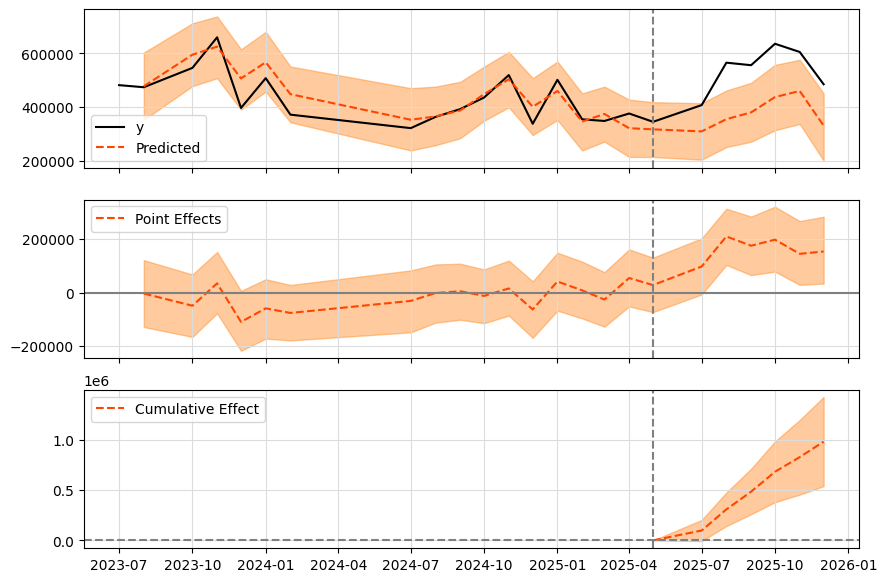

Pre-period R²: 0.676
Pre-period MAE: 38616.98
Pre-period RMSE: 49418.90
Proportion inside 95% CI: 100.00%


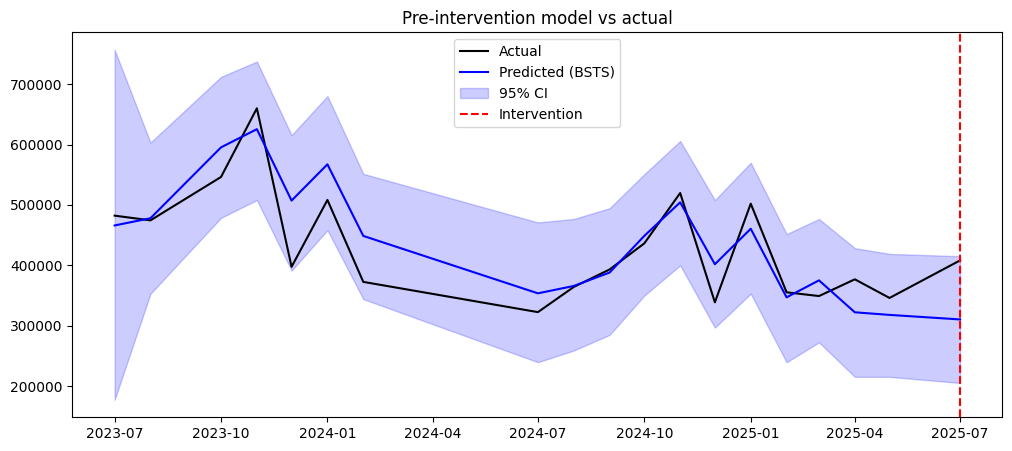

In [ ]:
bsts_monthly_data_masked = bsts_monthly_data_masked.dropna(axis=0) # Drop NaNs
causal_impact_pipeline(bsts_monthly_data_masked.drop(['ppc_spend', 'meta_spend'], axis=1), 'dining_only_revenue',
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 100,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01 # Controls how strongly covariates can influence the outcome
                                   })

Increasing seasonal_initial_scale does not appear to be improving the results any further.

## Model verification

Run the model against non-dining sales - is the model indicating that dining PPC spend has increased non-dining sales?

In [ ]:
# Make a copy of the dataframe, and move the new target column to the front
test_df = bsts_monthly_data_masked.copy()
col = test_df.pop('non_dining_revenue')
test_df.insert(0, 'non_dining_revenue', col)

In [ ]:
causal_impact_pipeline(test_df.drop(['dining_only_revenue', # Must drop now as it's not longer the target col
                                     'ppc_spend', 'meta_spend'], axis=1),
                       'non_dining_revenue', # Specify new target column
                       intervention_date, start_date_earlier, 'Pre-intervention model vs actual',
                       model_args={'fit_method': 'hmc',
                                   'seasonal_initial_scale': 100,
                                   'seasonal_drift_scale': 0.1,
                                   'prior_regression_sd': 0.01
                                   })